# Corporación Favorita Grocery Sales Forecasting

Kaggle соревнование в котором необходимо спрогнозировать продажи тысяч семейств товаров, продаваемых в магазинах Favorita, расположенных в Эквадоре. Данные обучения включают даты, информацию о магазине и продукте, информацию о том, продвигался ли этот товар, а также номера продаж. Так же есть дополнительные файлы с катировками нефти и праздниками.

[ссылка на соревнование](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview
)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:
train_df = pd.read_csv('drive/MyDrive/data/train.csv',index_col='id')
test_df = pd.read_csv('drive/MyDrive/data/test.csv',index_col='id')

# EDA

In [5]:
train_df

date  store_nbr                      family     sales  \
id                                                                     
0        2013-01-01          1                  AUTOMOTIVE     0.000   
1        2013-01-01          1                   BABY CARE     0.000   
2        2013-01-01          1                      BEAUTY     0.000   
3        2013-01-01          1                   BEVERAGES     0.000   
4        2013-01-01          1                       BOOKS     0.000   
...             ...        ...                         ...       ...   
3000883  2017-08-15          9                     POULTRY   438.133   
3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
id                    
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

In [112]:
# сделаем даты типом datetime
train_df.date = pd.to_datetime(train_df.date)
test_df.date= pd.to_datetime(test_df.date)

train_df['year'] = train_df.date.dt.year
test_df['year'] = test_df.date.dt.year

train_df['month'] = train_df.date.dt.month
test_df['month'] = test_df.date.dt.month

train_df['dayofmonth'] = train_df.date.dt.day
test_df['dayofmonth'] = test_df.date.dt.day

train_df['dayofweek'] = train_df.date.dt.dayofweek
test_df['dayofweek'] = test_df.date.dt.dayofweek

train_df['dayname'] = train_df.date.dt.strftime('%A')
test_df['dayname'] = test_df.date.dt.strftime('%A')

В соревновании необходимо предсказать продажи на последние 2 недели августа 2017

In [113]:
print('Train: ',min(train_df.date),max(train_df.date))
print('\n')
print('Test: ',min(test_df.date),max(test_df.date))

Train:  2013-01-01 00:00:00 2017-08-15 00:00:00


Test:  2017-08-16 00:00:00 2017-08-31 00:00:00


Onpromotion показывает общее количество товаров в семействе продуктов, которые продвигались в магазине на определенную дату

In [114]:
train_df.onpromotion.unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In [9]:
train_df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

## Ежегодный средний рост продаж
- почти у всех продуктов продажи стабильно росли до 2017

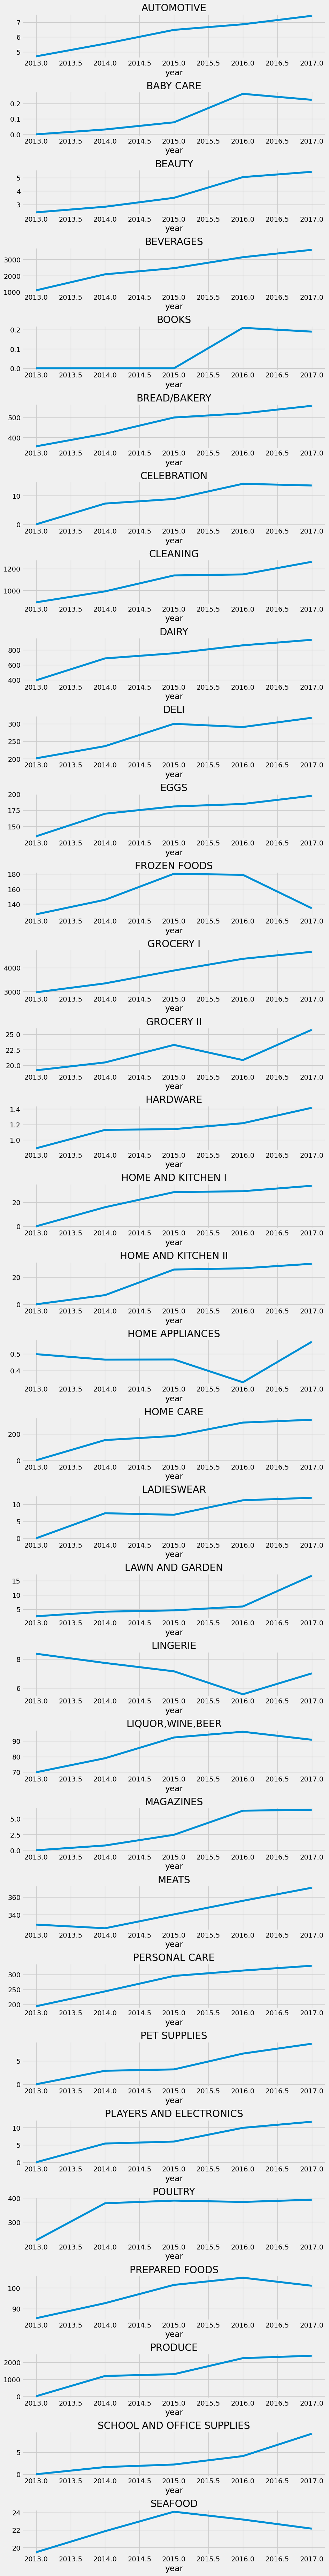

In [12]:
fig= plt.figure(figsize=(10,90))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(train_df.family.unique()):
    ax = fig.add_subplot(33,1,i+1)
    train_df.query('family==@product').groupby(['year']).sales.mean().plot()
    plt.title(product);


## Помесячные продажи по годам
- смортря на месяцы явные эффекты проследить трудно

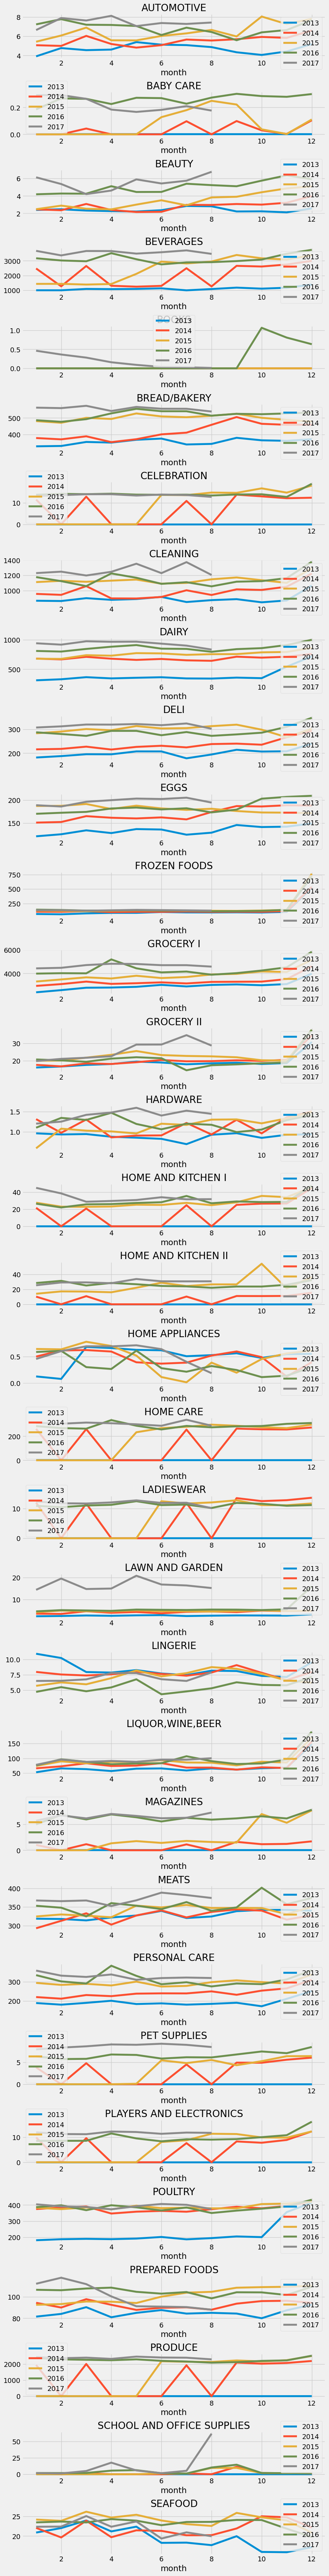

In [13]:
fig= plt.figure(figsize=(10,90))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(train_df.family.unique()):
    ax = fig.add_subplot(33,1,i+1)
    select = train_df.query('family==@product')
    for year in [2013,2014,2015,2016,2017]:
        select.query('year==@year').groupby('month').sales.mean().plot(ax=ax,label=year)
    plt.title(product)
    ax.legend();

Пропущенных значений в датасете нет

In [14]:
print(train_df.isna().sum())
print(test_df.isna().sum())

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
dayofmonth     0
dayofweek      0
dayname        0
dtype: int64
date           0
store_nbr      0
family         0
onpromotion    0
year           0
month          0
dayofmonth     0
dayofweek      0
dayname        0
dtype: int64


## Зарплата выплачивается в середине и в конце месяца, не слишком явно видно, что в эти дни есть два пика

Text(0.5, 1.0, 'Sales Average by Day of Month')

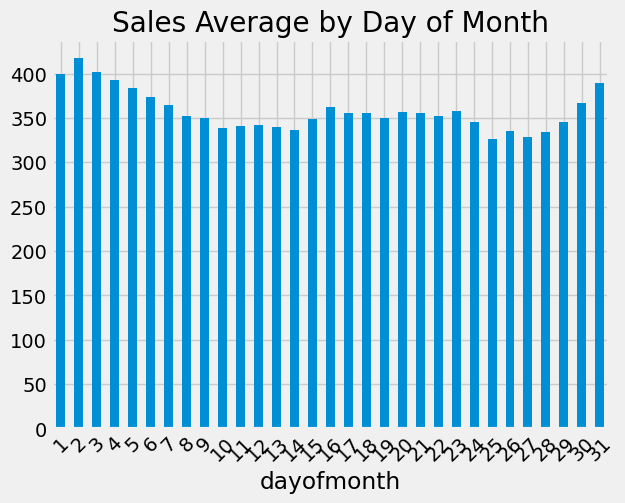

In [19]:
train_df.groupby('dayofmonth').sales.mean().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Sales Average by Day of Month')


## Много людей совершвло покупки на выходных

Text(0.5, 1.0, 'Average Sales by Day of week')

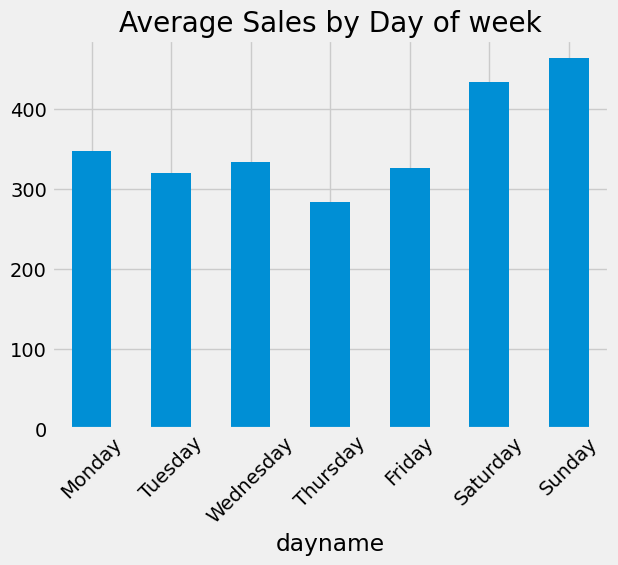

In [20]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
train_df.groupby('dayname').sales.mean().reindex(index=order).plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Average Sales by Day of week')

## Ранжирование прожад в зависимости от магазинов
- на продажи влияет так же расположение магазина и другое, что будет проанализировано из других .csv файлов

Text(0.5, 1.0, 'Sales Ranking by Store')

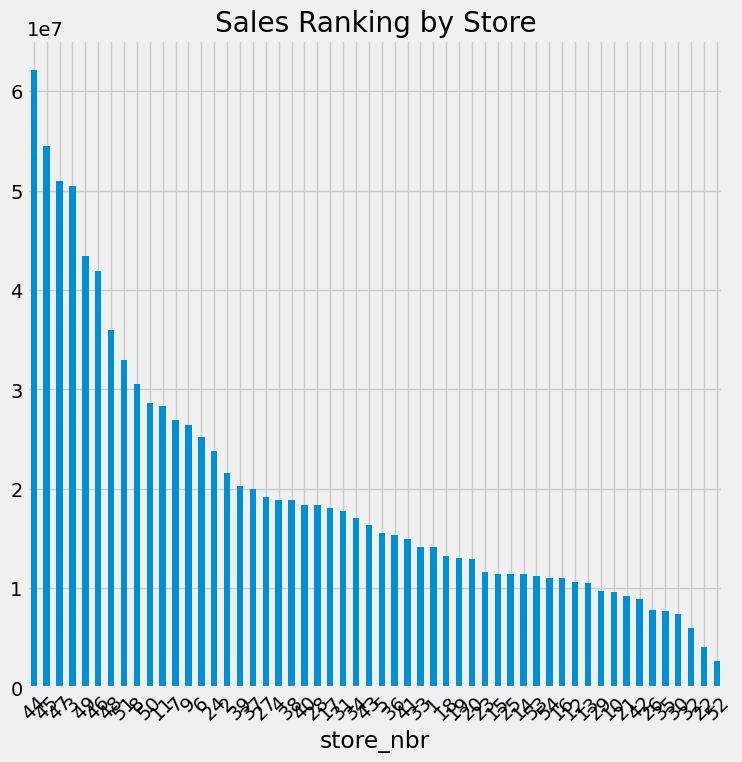

In [23]:
plt.figure(figsize=(8,8))
train_df.groupby('store_nbr').sales.sum().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Sales Ranking by Store')

Text(0.5, 1.0, 'Promotion Items Ranking by Store')

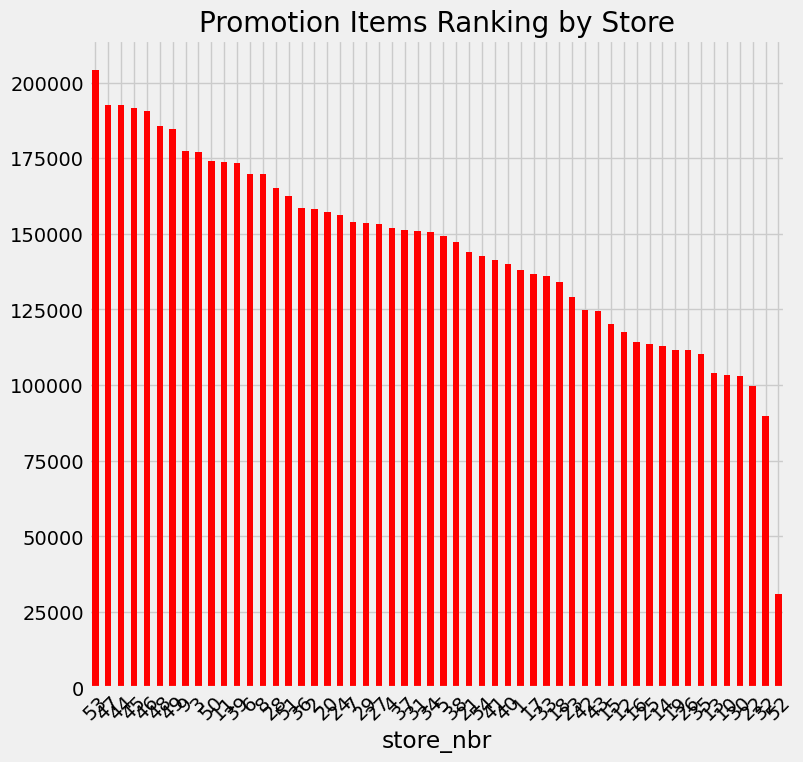

In [25]:
plt.figure(figsize=(8,8))
train_df.groupby('store_nbr').onpromotion.sum().sort_values(ascending=False).plot(kind='bar',color='red')
plt.xticks(rotation=45)
plt.title('Promotion Items Ranking by Store')

## Количество промоакций явно положительно кореллирует с продажами

Text(0.5, 1.0, 'Promotion and Sales Relationship')

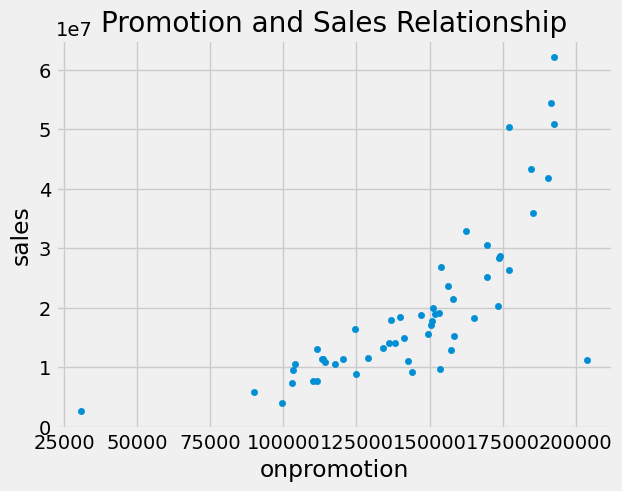

In [26]:
train_df.groupby('store_nbr')[['onpromotion','sales']].sum().plot.scatter('onpromotion','sales')
plt.title('Promotion and Sales Relationship')

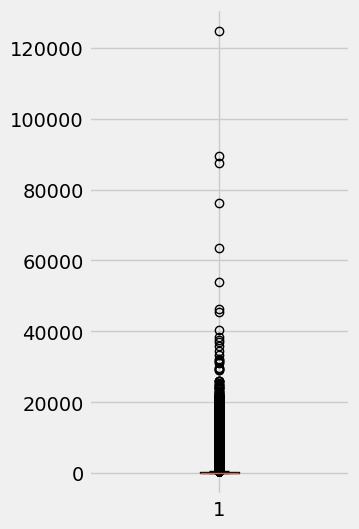

In [35]:
fig = plt.figure(figsize=(3,6))
plt.boxplot(train_df['sales'].values)
plt.show()

## Oil CSV

Эквадор является нефтезависимой страной

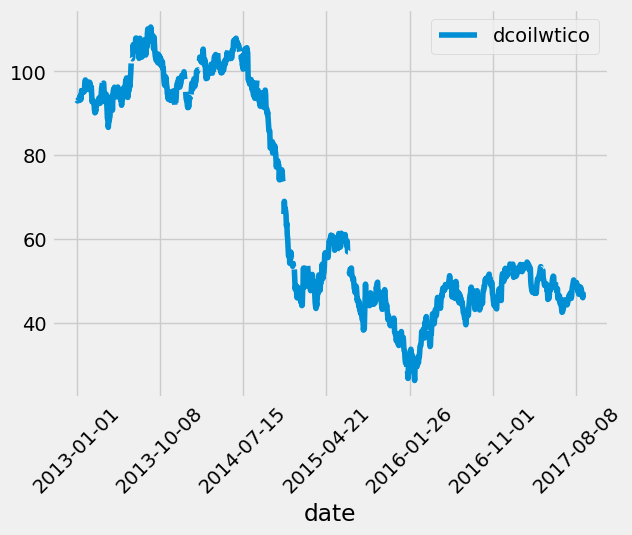

In [115]:
oil = pd.read_csv('drive/MyDrive/data/oil.csv',index_col='date')
oil.plot();
plt.xticks(rotation=45);

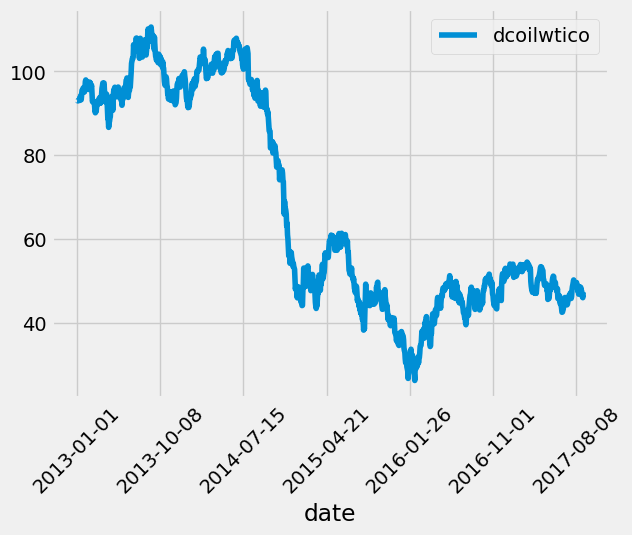

In [116]:
# заполним пропуски
oil = oil.interpolate(method='linear')
oil.iloc[0] = oil.iloc[1]
oil.plot();
plt.xticks(rotation=45);

In [117]:
import datetime

# Некоторые дни пропущены, заполним их

start_date = train_df.date.min()
# от начальной даты в трейне до конечной в тестовой
number_of_days = 1704 #1703
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')

<Axes: xlabel='date'>

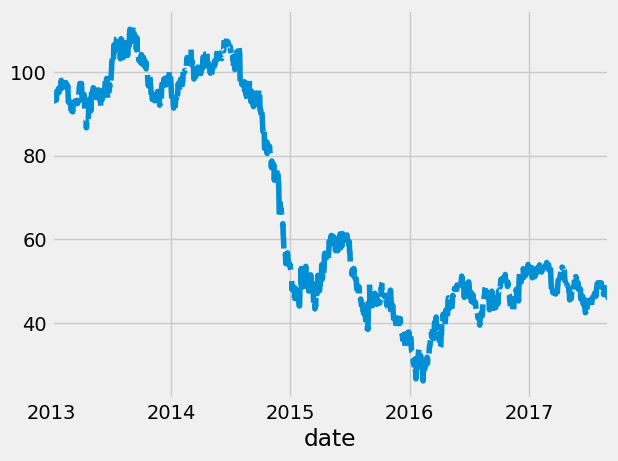

In [118]:
oil.set_index('date').dcoilwtico.plot()

In [119]:
oil['date_str'] = oil.index.astype(str)

In [120]:
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()

In [121]:
# добавим к трейну
train_df['date_str'] = train_df.date.astype(str)

train_df = pd.merge(train_df,oil,how='left',on='date_str')
train_df.drop(columns='date_str',axis=1,inplace=True)

KeyError: 'date_str'

In [122]:
test_df['date_str'] = test_df.date.astype(str)
test_df = pd.merge(test_df,oil,how='left', on='date_str')

test_df.drop(columns='date_str',axis=1,inplace=True)

KeyError: 'date_str'

In [68]:
plt.figure(figsize=(10,10))
train_df.groupby('family')[['sales','dcoilwtico']].corr().iloc[0::2,-1].sort_values()

family                           
HOME CARE                   sales   -0.453710
MAGAZINES                   sales   -0.380593
HOME AND KITCHEN II         sales   -0.375661
PRODUCE                     sales   -0.340423
HOME AND KITCHEN I          sales   -0.328061
PLAYERS AND ELECTRONICS     sales   -0.327215
BEVERAGES                   sales   -0.318847
PET SUPPLIES                sales   -0.307063
CELEBRATION                 sales   -0.294697
LADIESWEAR                  sales   -0.255375
DAIRY                       sales   -0.220657
PERSONAL CARE               sales   -0.204594
BEAUTY                      sales   -0.203606
GROCERY I                   sales   -0.195793
DELI                        sales   -0.190362
BREAD/BAKERY                sales   -0.177374
LAWN AND GARDEN             sales   -0.164715
CLEANING                    sales   -0.159257
AUTOMOTIVE                  sales   -0.145956
BABY CARE                   sales   -0.122380
POULTRY                     sales   -0.114485


<Figure size 1000x1000 with 0 Axes>

Некоторые семества продуктов (Home Care,Magazines,Home и Kitchen II,Produce,Home и Kitchen I) имеют более выраженную корелляцию с нефтью, но она все равно мала

## Stores CSV

In [69]:
stores = pd.read_csv('drive/MyDrive/data/stores.csv',index_col='store_nbr')
train_df = pd.merge(train_df,stores,how='left',on='store_nbr')
test_df = pd.merge(test_df,stores,how='left',on='store_nbr')

In [74]:
stores.head(10)

city                           state type  cluster
store_nbr                                                             
1                  Quito                       Pichincha    D       13
2                  Quito                       Pichincha    D       13
3                  Quito                       Pichincha    D        8
4                  Quito                       Pichincha    D        9
5          Santo Domingo  Santo Domingo de los Tsachilas    D        4
6                  Quito                       Pichincha    D       13
7                  Quito                       Pichincha    D        8
8                  Quito                       Pichincha    D        8
9                  Quito                       Pichincha    B        6
10                 Quito                       Pichincha    C       15

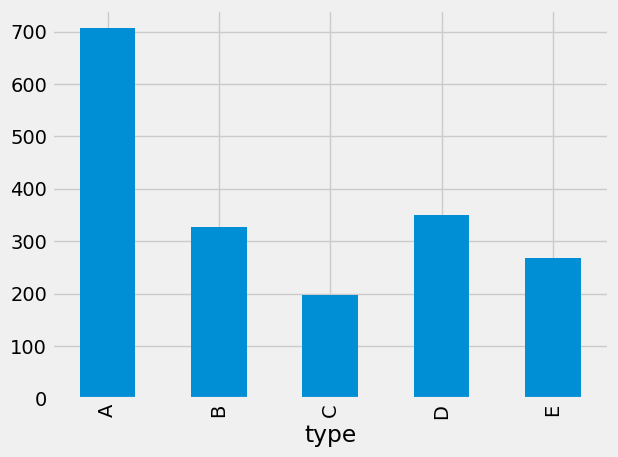

In [70]:
train_df.groupby(['type']).sales.mean().plot(kind='bar');

Из графика можно сделать вывод, что тип A - самый большой магазин, а С - самый маленький

Text(0.5, 1.0, 'Number of Stores by City')

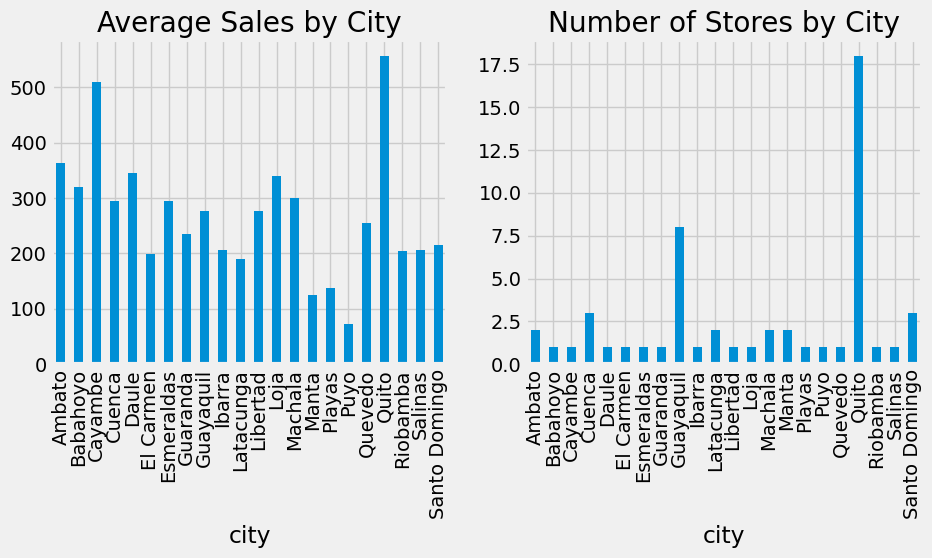

In [75]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
train_df.groupby(['city']).sales.mean().plot(kind='bar')
plt.title('Average Sales by City')
ax2 = plt.subplot(1,2,2)
train_df.groupby(['city'])['store_nbr'].nunique().plot(kind='bar')
plt.title('Number of Stores by City')

Очевидно будет положительная корелляция между количеством магазином и численностью населения города

<Axes: xlabel='cluster'>

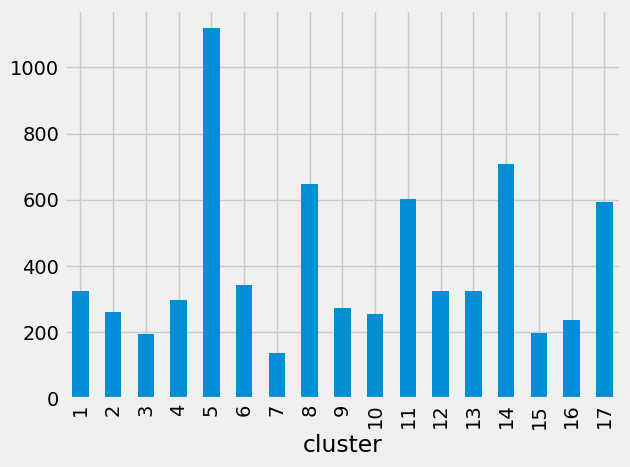

In [76]:
train_df.groupby(['cluster']).sales.mean().plot(kind='bar')

In [77]:
train_df.groupby(['cluster','store_nbr','city','type']).nunique()

date  family  sales  onpromotion  year  \
cluster store_nbr city          type                                           
1       24        Guayaquil     D     1684      33  15182          160     5   
        25        Salinas       D     1684      33  12023          149     5   
        27        Daule         D     1684      33  15260          159     5   
2       37        Cuenca        D     1684      33  15065          173     5   
        42        Cuenca        D     1684      33   7676          157     5   
3       16        Santo Domingo C     1684      33   7431          116     5   
        30        Guayaquil     C     1684      33   6665          108     5   
        32        Guayaquil     C     1684      33   6402           97     5   
        33        Quevedo       C     1684      33   8091          130     5   
        35        Playas        C     1684      33   6851          107     5   
        40        Machala       C     1684      33   8998          127     5   
        54        El Carmen     C     1684      33   7546          180     5   
4       5         Santo Domingo D     1684      33  14753          165     5   
        38        Loja          D     1684      33  15025          169     5   
        41        Machala       D     1684      33  14040          165     5   
5       44        Quito         A     1684      33  18368          199     5   
6       9         Quito         B     1684      33  13939          155     5   
        11        Cayambe       B     1684      33  12111          152     5   
        20        Quito         B     1684      33   8613          154     5   
        21        Santo Domingo B     1684      33   6698          147     5   
        34        Guayaquil     B     1684      33  11151          139     5   
        39        Cuenca        B     1684      33  13105          170     5   
7       14        Riobamba      C     1684      33   7562          115     5   
        22        Puyo          C     1684      33   3970          114     5   
8       3         Quito         D     1684      33  17801          193     5   
        7         Quito         D     1684      33  15462          180     5   
        8         Quito         D     1684      33  16181          179     5   
9       4         Quito         D     1684      33  15031          168     5   
        23        Ambato        D     1684      33  13308          159     5   
10      26        Guayaquil     D     1684      33  10077          126     5   
        28        Guayaquil     E     1684      33  12604          148     5   
        29        Guayaquil     E     1684      33   7463          155     5   
        31        Babahoyo      B     1684      33  11503          140     5   
        36        Libertad      E     1684      33  11242          153     5   
        43        Esmeraldas    E     1684      33   9372          135     5   
11      45        Quito         A     1684      33  18217          199     5   
        49        Quito         A     1684      33  17364          194     5   
        52        Manta         A     1684      33   1681          103     5   
12      17        Quito         C     1684      33   8313          137     5   
13      1         Quito         D     1684      33  13668          155     5   
        2         Quito         D     1684      33  14579          174     5   
        6         Quito         D     1684      33  15947          177     5   
        53        Manta         D     1684      33  10030          239     5   
14      46        Quito         A     1684      33  17221          189     5   
        47        Quito         A     1684      33  18004          200     5   
        48        Quito         A     1684      33  16930          191     5   
        50        Ambato        A     1684      33  16358          183     5   
15      10        Quito         C     1684      33   7330          108     5   
        12        Latacunga     C     

## Holidays_Events.CSV

In [78]:
holiday_df = pd.read_csv('drive/MyDrive/data/holidays_events.csv')
holiday_df.query('transferred==True')

# transferred day не празднуется
holiday_df = holiday_df.query('transferred ==False')
holiday_df.description = holiday_df.description.str.replace('Traslado ','')

# национальные
national = holiday_df.query('locale=="National"')

day_off = national.query('type!="Work Day" or type!="Event"').set_index('date')['description'].to_dict()

train_df['date_str'] = train_df.date.astype(str)
test_df['date_str'] = test_df.date.astype(str)

train_df['national_holiday'] = [1 if a in day_off else 0 for a in train_df.date_str]
test_df['national_holiday'] = [1 if a in day_off else 0 for a in test_df.date_str]

event = national.query('type=="Event"').set_index('date')['description'].to_dict()

train_df['national_event'] =[1 if a in event else 0 for a in train_df.date_str]
test_df['national_event'] =[1 if a in event else 0 for a in test_df.date_str]

work_day = national.query('type=="Work Day"').set_index('date')['description'].to_dict()
train_df['national_workday'] = [1 if a in work_day else 0 for a in train_df.date_str]
test_df['national_workday'] = [1 if a in work_day else 0 for a in test_df.date_str]

# выходные
train_df['weekend'] = [1 if a>=5 else 0 for a in train_df.dayofweek]
test_df['weekend'] = [1 if a>=5 else 0 for a in test_df.dayofweek]

In [79]:
train_df.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month',
       'dayofmonth', 'dayofweek', 'dayname', 'dcoilwtico', 'city', 'state',
       'type', 'cluster', 'date_str', 'national_holiday', 'national_event',
       'national_workday', 'weekend'],
      dtype='object')

In [81]:
# локальные
local = holiday_df.query('locale=="Local"')
local_dic = local.set_index('date').locale_name.to_dict()
train_df['local_holiday']=[1 if b in local_dic and local_dic[b]== a else 0 for a,b in zip(train_df.city,train_df.date_str)]
test_df['local_holiday']=[1 if b in local_dic and local_dic[b]== a else 0 for a,b in zip(test_df.city,test_df.date_str)]

In [82]:
# региональные
regional = holiday_df.query('locale=="Regional"')
regional_dic = regional.set_index('date').locale_name.to_dict()
train_df['regional_holiday']= [1 if b in regional_dic and regional_dic[b]== a else 0 for a,b in zip(train_df.state,train_df.date_str)]
test_df['regional_holiday']= [1 if b in regional_dic and regional_dic[b]== a else 0 for a,b in zip(test_df.state,test_df.date_str)]

## Transaction.CSV

In [83]:
transaction_df = pd.read_csv('drive/MyDrive/data/transactions.csv')

In [84]:
transaction_df

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

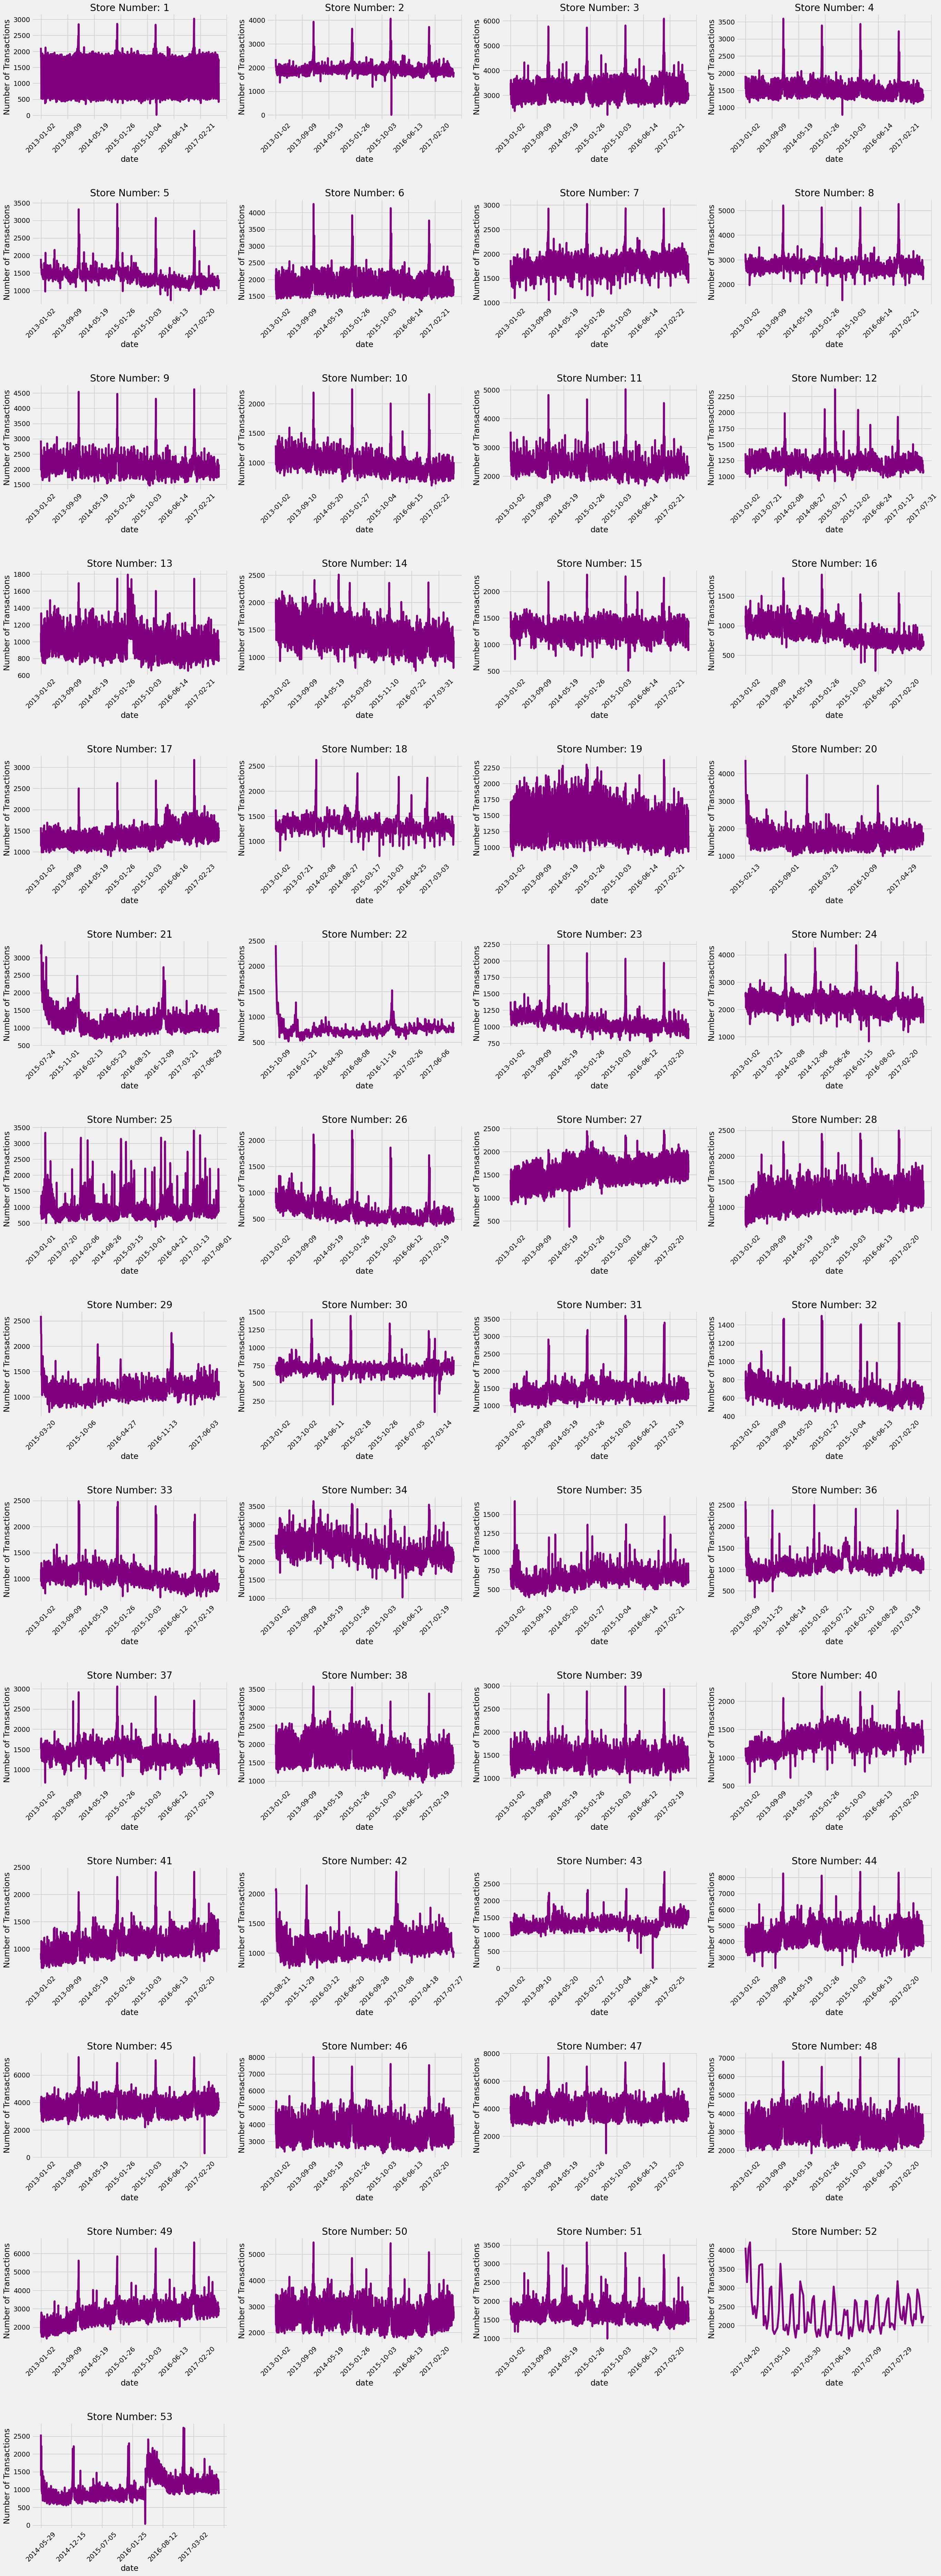

In [86]:
fig= plt.figure(figsize=(30,90))
fig.subplots_adjust(hspace=0.75)
for i,store in enumerate(range(1,54)):
    ax = fig.add_subplot(14,4,i+1)
    transaction_df.set_index('date').query('store_nbr==@store').transactions.plot(c='purple');
    plt.title('Store Number: ' + str(store));
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45);

В каждом магазине есть пики продаж

In [87]:
len(train_df.query('date_str=="2013-01-01"'))

1782

# Подготовка данных и feature engineering

In [89]:
# проведем логарифмическое преобразование для сглаживания и нормализации
train_df.sales = np.log1p(train_df.sales)

In [92]:
# используем лаги для генерации новых фичей,
# создадим признаки, указывающие на количество продаж на периоды назад
train_df['Istest'] = False
test_df['Istest'] = True

full = pd.concat((train_df,test_df))

# удалим день високосного года
full = full.query('date_str !="2016-02-29"')

full['Lag_16'] = full['sales'].shift(1782*16)
full['Lag_17'] = full['sales'].shift(1782*17)
full['Lag_18'] = full['sales'].shift(1782*18)
full['Lag_19'] = full['sales'].shift(1782*19)
full['Lag_20'] = full['sales'].shift(1782*20)
full["Lag_21"] = full['sales'].shift(1782*21)
full['Lag_22'] = full['sales'].shift(1782*22)
full['Lag_28'] = full['sales'].shift(1782*28)
full['Lag_31'] = full['sales'].shift(1782*31)

full['Lag_365'] = full['sales'].shift(1782*365)

train_df = full.query('Istest==False')
test_df = full.query('Istest ==True')

<ipython-input-92-4bd96072d9c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Istest'] = True


In [93]:
train_df = train_df.dropna(subset=['Lag_365'],axis=0)